<a href="https://colab.research.google.com/github/ksbrown1993/lab4/blob/master/Dynamics_of_Axisymmetric_Membrane_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Authors: Katie Brown, Philipp Suhrcke, Quentin Vagne

Test the system of equations and the linear system with a simple sphere. Create a linear system of the form: Ax = b. 

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import numpy
import sys

In [0]:
#Here is the code to import the values of Css, Cthth, and christ from files given in binary format
# The files Css, Cthth, and Gamma contain respectively Css, Cthth and the christoffel symbol
# Here are the info for this particular example:
# It is sampled  on a uniform grid with N=999 points
# It goes from s=0 to s=5.82147363745928 (<- this is what you will put in h)
# The parameter values are:
# dp=2 c0=0 eta=0.3 eta_b=0.7 zeta_prime=0 zeta_tilde=1 gamma=1 kappa=1
# The goal is to solve for vs and vn, and you should find approximately vn=0 and vs=vs_example
Css_example=np.fromfile('Css',np.float64)
Cthth_example=np.fromfile('Cthth',np.float64)
christ_example=np.fromfile('Gamma',np.float64)
vs_example=np.fromfile('vs',np.float64)

In [0]:
# set Parameters

N = len(Css_example)        # number of points along the sphere
kappa = 1       # bending rigidity
C0 = 0          # spontaneous curvature
zeta_1 = 0      # active force terms
zeta_tilde = 1
R1 = 2           # radius of sphere
R2 = 2
Css = Css_example   # curvature along s
Cthth = Cthth_example # curvature along theta
Css_ghost = np.array([Css[2],Css[1],Css[-2],Css[-3]])
Cthth_ghost = np.array([Cthth[2],Cthth[1],Cthth[-2],Cthth[-3]])
gamma = 1       # tension constant
eta = .3        # shear
eta_b = 0.7     # bulk
P = 2           # pressure
h = 5.82147363745928 # h = L in this case
du = 1/(N-1)     # distance between two points on the line u 0->1
pi = np.linspace(0,np.pi,N)      # split sphere into N equidistant points
christ = christ_example  # Christoffelsymbol
christ[0] = 0                       # poles are not really 0, but they are not used at the poles anyway
christ[N-1] = 0 

first_pole = 0
first_point = 1
second_point = 2
second_to_last_point = N-3
last_point = N-2
second_pole = N-1


In [0]:
# function definitions
def calculate_temp_a(i):
   temp_a = 1/(12*du*h)*((eta+eta_b)*Css[i] + (eta_b-eta)*Cthth[i])
   return temp_a

def calculate_temp_b(i):
   temp_b = 2/(3*du*h)*((eta+eta_b)*Css[i] + (eta_b-eta)*Cthth[i])
   return temp_b

def calculate_temp_c(i):
  temp_c = christ[i]*((eta+eta_b)*Cthth[i] + (eta_b-eta)*Css[i])  
  return temp_c

def calculate_temp_mu(i):
  temp_mu = ((eta+eta_b)*((Css[i])**2 + (Cthth[i])**2) + 2*(eta_b-eta)*Cthth[i]*Css[i])
  return temp_mu

def calculate_temp_d(i):
  temp_d = 1/(12*du*h)*2*Cthth[i]*(eta_b+eta)
  return temp_d

def calculate_temp_e(i):
  temp_e = 2/(3*du*h)*2**Cthth[i]*(eta_b+eta)
  return temp_e

def calculate_temp_f(i):
  temp_f = 2*Cthth[i]*(eta_b-eta)*christ[i] 
  return temp_f

def calculate_temp_nu(i):
  temp_nu= 2*Cthth[i]*((eta+eta_b)*Css[i] + (eta_b-eta)*Cthth[i])
  return temp_nu

def calculate_temp_phi(i):
  temp_phi= 4*eta_b*(Css[i])**2 
  return temp_phi

def calculate_temp_k(i):
  temp_k= 2*(2/(3*du*h))*4*eta_b*Css[i]
  return temp_k

def calculate_temp_j(i):
  temp_j =  2/(12*du*h)*4*eta_b*Css[i]
  return temp_j

def calculate_temp_M(i):
  temp_M = (2*Css[i]*(zeta_1+zeta_tilde)+gamma)*2*Css[i] - Css[i]**2*(4*zeta_tilde+2*kappa*C0) - 8/3*kappa*dsdsCss
  return temp_M

def calculate_temp_L(i):
  temp_L = ((Css[i]+Cthth[i])*(zeta_1+zeta_tilde) + gamma)*(Css[i]+Cthth[i]) - Css[i]*Cthth[i]*(4*zeta_tilde+2*kappa*C0) \
                - kappa/2 * (Css[i]+Cthth[i])*(Css[i]-Cthth[i])**2 - kappa*((dsdsCss+((Cthth[i]-Css[i])*(christ[i]**2+Css[i]*Cthth[i]) \
                +christ[i]*dsCss))+christ[i]*(dsCss+christ[i]*(Css[i]-Cthth[i])))
  return temp_L

def calculate_temp_K(i):
  temp_K = 2*Cthth[i]*(gamma+(zeta_1-zeta_tilde-kappa*C0)*(Css[i]+Cthth[i])+kappa/2 * (Css[i]+Cthth[i])**2 + Css[i]*(2*zeta_tilde+kappa*C0 \
                -kappa*(Css[i]+Cthth[i]))) - 2*christ[i]*kappa*(dsCss+christ[i]*(Css[i]-Cthth[i]))
  return temp_K

def calculate_dsCss_first_point(i):
  dsCss = (1/(12*du)*Css_ghost[1] - 2/(3*du)*Css[i-1] + 2/(3*du)*Css[i+1] -1/(12*du)*Css[i+2])/h 
  return dsCss
def calculate_dsCss_last_point(i):
  dsCss = (1/(12*du)*Css[i-2] - 2/(3*du)*Css[i-1] + 2/(3*du)*Css[i+1] -1/(12*du)*Css_ghost[2])/h
  return dsCss
def calculate_dsCss(i):
  dsCss = (1/(12*du)*Css[i-2] - 2/(3*du)*Css[i-1] + 2/(3*du)*Css[i+1] -1/(12*du)*Css[i+2])/h  
  return dsCss

def calculate_dsdsCss_first_pole(i):
  dsdsCss = (-1/(12*du**2)*Css_ghost[0] + 4/(3*du**2)*Css_ghost[1] - 5/(2*du**2)*Css[i] + 4/(3*du**2)*Css[i+1] - 1/(12*du**2)*Css[i+2])/(h**2)
  return dsdsCss
def calculate_dsdsCss_first_point(i):
  dsdsCss = (-1/(12*du**2)*Css_ghost[1] + 4/(3*du**2)*Css[i-1] - 5/(2*du**2)*Css[i] + 4/(3*du**2)*Css[i+1] - 1/(12*du**2)*Css[i+2])/(h**2)
  return dsdsCss
def calculate_dsdsCss_last_point(i):
  dsdsCss = (-1/(12*du**2)*Css[i-2] + 4/(3*du**2)*Css[i-1] - 5/(2*du**2)*Css[i] + 4/(3*du**2)*Css[i+1] - 1/(12*du**2)*Css_ghost[2])/(h**2)
  return dsdsCss
def calculate_dsdsCss(i):
  dsdsCss = (-1/(12*du**2)*Css[i-2] + 4/(3*du**2)*Css[i-1] - 5/(2*du**2)*Css[i] + 4/(3*du**2)*Css[i+1] - 1/(12*du**2)*Css[i+2])/(h**2)
  return dsdsCss


[-1.781149   -1.94374354 -1.78111471 ... -1.94374354 -1.78111471
  0.        ]


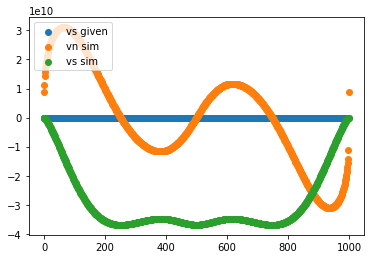

In [0]:
# create matrix A and the vector b with parameters
A = np.zeros([2*N-2,2*N-2])
b = np.zeros([2*N-2])

####Note that elif is faster than if statements
####Brainstorm/research ideas how to vectorize and speed up computation time
####When N=5000, takes 7 seconds local
####When N=7500, takes 20 seconds local
####When N=9000, takes 36 seconds local
####When N=10000, take 50 seconds local
####When N=15000, takes 4.5 min local
#Complexity is O(2^N) — Exponential due to recursiveness

for i in range(N):
    # calculaQte the parameters
    temp_a = calculate_temp_a(i)
    temp_b = calculate_temp_b(i)
    temp_c = calculate_temp_c(i) 
    temp_mu = calculate_temp_mu(i)
    temp_d = calculate_temp_d(i)
    temp_e = calculate_temp_e(i)
    temp_f = calculate_temp_f(i) 
    temp_nu = calculate_temp_nu(i)
    temp_phi = calculate_temp_phi(i) 
    temp_k = calculate_temp_k(i) 
    temp_j = calculate_temp_j(i)

    if i == first_pole:
      dsdsCss = calculate_dsdsCss_first_pole(i) 
      temp_M = calculate_temp_M(i)    
      A[i,[i, i+1, i+3]] = [temp_phi, temp_k, -temp_j]
      b[i] = P-temp_M

    elif i == first_point: 
      dsCss = calculate_dsCss_first_point(i)
      dsdsCss = calculate_dsdsCss_first_point(i)
      temp_L = calculate_temp_L(i)      
      temp_K = calculate_temp_K(i)
      A[2*i-1,[2*i-1, 2*i, 2*i+1, 2*i+3]] = [temp_c - temp_a, temp_mu, temp_b, -temp_a]
      A[2*i  ,[2*i-1, 2*i, 2*i+1, 2*i+3]] = [temp_f - temp_d, temp_nu, temp_e, -temp_d]
      b[2*i-1] = P - temp_L
      b[2*i] = P-temp_K

    elif i == second_point:
      dsCss = calculate_dsCss(i)
      dsdsCss = calculate_dsdsCss(i)
      temp_L = calculate_temp_L(i)      
      temp_K = calculate_temp_K(i)
      A[2*i-1,[2*i-3, 2*i-1, 2*i, 2*i+1, 2*i+3]] = [-temp_b, temp_c, temp_mu, temp_b, -temp_a]
      A[2*i  ,[2*i-3, 2*i-1, 2*i, 2*i+1, 2*i+3]] = [-temp_e, temp_f, temp_nu, temp_e, -temp_d]
      b[2*i-1] = P - temp_L
      b[2*i] = P-temp_K

    elif (i > second_point) and (i < second_to_last_point):
      dsCss = calculate_dsCss(i)
      dsdsCss = calculate_dsdsCss(i)
      temp_L = calculate_temp_L(i)      
      temp_K = calculate_temp_K(i)
      A[2*i-1,[2*i-5, 2*i-3, 2*i-1, 2*i, 2*i+1, 2*i+3]] = [temp_a, -temp_b, temp_c, temp_mu, temp_b, -temp_a]
      A[2*i  ,[2*i-5, 2*i-3, 2*i-1, 2*i, 2*i+1, 2*i+3]] = [temp_d, -temp_e, temp_f, temp_nu, temp_e, -temp_d]
      b[2*i-1] = P - temp_L
      b[2*i] = P-temp_K

    elif i == second_to_last_point:
      dsCss = calculate_dsCss(i)
      dsdsCss = calculate_dsdsCss(i)
      temp_L = calculate_temp_L(i)      
      temp_K = calculate_temp_K(i)
      A[2*i-1,[2*i-5, 2*i-3, 2*i-1, 2*i, 2*i+1]] = [temp_a, -temp_b, temp_c, temp_mu, temp_b]
      A[2*i  ,[2*i-5, 2*i-3, 2*i-1, 2*i, 2*i+1]] = [temp_d, -temp_e, temp_f, temp_nu, temp_e]
      b[2*i-1] = P - temp_L
      b[2*i] = P-temp_K

    elif i == last_point:
      dsCss = calculate_dsCss_last_point(i)
      dsdsCss = calculate_dsdsCss_last_point(i)
      temp_L = calculate_temp_L(i)      
      temp_K = calculate_temp_K(i)
      A[2*i-1,[2*i-5, 2*i-3, 2*i-1, 2*i]] = [temp_a, -temp_b, temp_c + temp_a, temp_mu]
      A[2*i  ,[2*i-5, 2*i-3, 2*i-1, 2*i]] = [temp_d, -temp_e, temp_f + temp_d, temp_nu]
      b[2*i-1] = P - temp_L
      b[2*i] = P-temp_K
   
    elif i == second_pole:
      A[2*i-1,0] = 1
      A[2*i-1,2*i-1] = -1
    else:
      pass
  
x = np.linalg.solve(A,b)
print(b)

v_n = x[::2] #select every other point to extract v_n from x
v_n = np.append(v_n, x[-1])
v_s = np.zeros(N)   # at the poles v_s is 0
v_s[1:len(v_s)-1] = x[1:len(x)-2:2] #select every other point to extract v_s from x
plt.scatter(np.arange(0,N),vs_example)
plt.scatter(np.arange(0,len(v_n)),v_n)
plt.scatter(np.arange(0,len(v_s)),v_s)
plt.legend(["vs given", "vn sim", "vs sim"], loc ="upper left")

The next one is the same code but written in a different way.

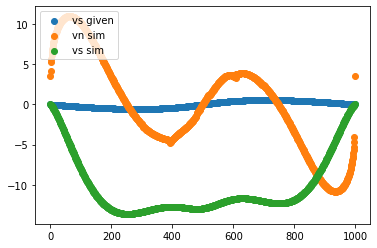

In [0]:
ds = h/(N-1)

# create matrix A and the vector b with parameters
A = np.zeros([2*N-2,2*N-2])
b = np.zeros([2*N-2])

for i in range(N):
    # for the first pole
    if i == 0: 
        A[0,0] = 4*eta_b*(Css[0])**2    # Phi_0
        A[0,1] = 2*(2/(3*ds))*4*eta_b*Css[0] # k_0
        A[0,3] = -2/(12*ds)*4*eta_b*Css[0] # j_0
        dsdsCss = -1/(12*ds**2)*Css_ghost[0] + 4/(3*ds**2)*Css_ghost[1] - 5/(2*ds**2)*Css[0] + 4/(3*ds**2)*Css[1] - 1/(12*ds**2)*Css[2]
        b[0] = P-(2*Css[0]*(zeta_1+zeta_tilde)+gamma)*2*Css[0] + Css[0]**2*(4*zeta_tilde+2*kappa*C0) + 8/3*kappa*dsdsCss
    # calculate the parameters
    temp_a = 1/(12*ds)*((eta+eta_b)*Css[i] + (eta_b-eta)*Cthth[i])
    temp_b = 2/(3*ds)*((eta+eta_b)*Css[i] + (eta_b-eta)*Cthth[i])
    temp_c = christ[i]*((eta+eta_b)*Cthth[i] + (eta_b-eta)*Css[i])  ########should it be christ[1] or christ[i]
    temp_mu = ((eta+eta_b)*((Css[i])**2 + (Cthth[i])**2) + 2*(eta_b-eta)*Cthth[i]*Css[i])
    
    temp_d = 1/(12*ds)*2*Cthth[i]*(eta_b+eta)
    temp_e = 2/(3*ds)*2**Cthth[i]*(eta_b+eta)
    temp_f = 2*Cthth[i]*(eta_b-eta)*christ[i]  ########should it be christ[1] or christ[i]
    temp_nu = 2*Cthth[i]*((eta+eta_b)*Css[i] + (eta_b-eta)*Cthth[i])
    
    # first point
    if i == 1:
        # Normal force balance
        dsCss = 1/(12*ds)*Css_ghost[1] - 2/(3*ds)*Css[0] + 2/(3*ds)*Css[2] -1/(12*ds)*Css[3] ########should it be Css_ghost[0] or Css_ghost[1]??
        dsdsCss = -1/(12*ds**2)*Css_ghost[1] + 4/(3*ds**2)*Css[0] - 5/(2*ds**2)*Css[1] + 4/(3*ds**2)*Css[2] - 1/(12*ds**2)*Css[3] ########should it be Css_ghost[0] or Css_ghost[1]??
        temp_L = ((Css[1]+Cthth[1])*(zeta_1+zeta_tilde) + gamma)*(Css[1]+Cthth[1]) - Css[1]*Cthth[1]*(4*zeta_tilde+2*kappa*C0) \
                - kappa/2 * (Css[1]+Cthth[1])*(Css[1]-Cthth[1])**2 - kappa*((dsdsCss+((Cthth[1]-Css[1])*(christ[1]**2+Css[1]*Cthth[1]) \
                +christ[1]*dsCss))+christ[1]*(dsCss+christ[1]*(Css[1]-Cthth[1])))
        A[1,1] = (temp_c-temp_a)
        A[1,2] = temp_mu
        A[1,3] = temp_b
        A[1,5] = -temp_a
        b[1] = P - temp_L
        
        # First integral
        temp_K = 2*Cthth[1]*(gamma+(zeta_1-zeta_tilde-kappa*C0)*(Css[1]+Cthth[1])+kappa/2 * (Css[1]+Cthth[1])**2 + Css[1]*(2*zeta_tilde+kappa*C0 \
                -kappa*(Css[1]+Cthth[1]))) - 2*christ[1]*kappa*(dsCss+christ[1]*(Css[1]-Cthth[1]))
        
        A[2,1] = (temp_f-temp_d)
        A[2,2] = temp_nu
        A[2,3] = temp_e
        A[2,5] = -temp_d
        b[2] = P-temp_K
        
    # second point
    if i == 2:
        # Normal force balance
        dsCss = 1/(12*ds)*Css[i-2] - 2/(3*ds)*Css[i-1] + 2/(3*ds)*Css[i+1] -1/(12*ds)*Css[i+2]
        dsdsCss = -1/(12*ds**2)*Css[i-2] + 4/(3*ds**2)*Css[i-1] - 5/(2*ds**2)*Css[i] + 4/(3*ds**2)*Css[i+1] - 1/(12*ds**2)*Css[i+2]
        temp_L = ((Css[i]+Cthth[i])*(zeta_1+zeta_tilde) + gamma)*(Css[i]+Cthth[i]) - Css[i]*Cthth[i]*(4*zeta_tilde+2*kappa*C0) \
                - kappa/2 * (Css[i]+Cthth[i])*(Css[i]-Cthth[i])**2 - kappa*((dsdsCss+((Cthth[i]-Css[i])*(christ[i]**2+Css[i]*Cthth[i]) \
                +christ[i]*dsCss))+christ[i]*(dsCss+christ[i]*(Css[i]-Cthth[i])))
        A[2*i-1,2*i-3] = -temp_b 
        A[2*i-1,2*i-1] = temp_c
        A[2*i-1,2*i] = temp_mu
        A[2*i-1,2*i+1] = temp_b
        A[2*i-1,2*i+3] = -temp_a
        b[2*i-1] = P-temp_L
        
        # First integral
        temp_K = 2*Cthth[i]*(gamma+(zeta_1-zeta_tilde-kappa*C0)*(Css[i]+Cthth[i])+kappa/2 * (Css[i]+Cthth[i])**2 + Css[i]*(2*zeta_tilde+kappa*C0 \
                -kappa*(Css[i]+Cthth[i]))) - 2*christ[i]*kappa*(dsCss+christ[i]*(Css[i]-Cthth[i]))
        
        A[2*i,2*i-3] = -temp_e
        A[2*i,2*i-1] = temp_f
        A[2*i,2*i] = temp_nu
        A[2*i,2*i+1] = temp_e
        A[2*i,2*i+3] = -temp_d
        b[2*i] = P-temp_K
        
    # points between the two poles, which are not "affected" by the pole
    if (i > 2) and (i <= N-4):
        # Normal force balance
        dsCss = 1/(12*ds)*Css[i-2] - 2/(3*ds)*Css[i-1] + 2/(3*ds)*Css[i+1] -1/(12*ds)*Css[i+2]
        dsdsCss = -1/(12*ds**2)*Css[i-2] + 4/(3*ds**2)*Css[i-1] - 5/(2*ds**2)*Css[i] + 4/(3*ds**2)*Css[i+1] - 1/(12*ds**2)*Css[i+2]
        temp_L = ((Css[i]+Cthth[i])*(zeta_1+zeta_tilde) + gamma)*(Css[i]+Cthth[i]) - Css[i]*Cthth[i]*(4*zeta_tilde+2*kappa*C0) \
                - kappa/2 * (Css[i]+Cthth[i])*(Css[i]-Cthth[i])**2 - kappa*((dsdsCss+((Cthth[i]-Css[i])*(christ[i]**2+Css[i]*Cthth[i]) \
                +christ[i]*dsCss))+christ[i]*(dsCss+christ[i]*(Css[i]-Cthth[i])))     
        A[2*i-1,2*i-5] = temp_a
        A[2*i-1,2*i-3] = -temp_b 
        A[2*i-1,2*i-1] = temp_c
        A[2*i-1,2*i] = temp_mu
        A[2*i-1,2*i+1] = temp_b
        A[2*i-1,2*i+3] = -temp_a
        b[2*i-1] = P-temp_L
        
        # First integral
        temp_K = 2*Cthth[i]*(gamma+(zeta_1-zeta_tilde-kappa*C0)*(Css[i]+Cthth[i])+kappa/2 * (Css[i]+Cthth[i])**2 + Css[i]*(2*zeta_tilde+kappa*C0 \
                -kappa*(Css[i]+Cthth[i]))) - 2*christ[i]*kappa*(dsCss+christ[i]*(Css[i]-Cthth[i]))
        
        A[2*i,2*i-5] = temp_d
        A[2*i,2*i-3] = -temp_e
        A[2*i,2*i-1] = temp_f
        A[2*i,2*i] = temp_nu
        A[2*i,2*i+1] = temp_e
        A[2*i,2*i+3] = -temp_d
        b[2*i] = P-temp_K
        
    # two points before the last pole    
    if i == N-3:
        # Normal force balance
        dsCss = 1/(12*ds)*Css[i-2] - 2/(3*ds)*Css[i-1] + 2/(3*ds)*Css[i+1] -1/(12*ds)*Css[i+2]
        dsdsCss = -1/(12*ds**2)*Css[i-2] + 4/(3*ds**2)*Css[i-1] - 5/(2*ds**2)*Css[i] + 4/(3*ds**2)*Css[i+1] - 1/(12*ds**2)*Css[i+2]
        temp_L = ((Css[i]+Cthth[i])*(zeta_1+zeta_tilde) + gamma)*(Css[i]+Cthth[i]) - Css[i]*Cthth[i]*(4*zeta_tilde+2*kappa*C0) \
                - kappa/2 * (Css[i]+Cthth[i])*(Css[i]-Cthth[i])**2 - kappa*((dsdsCss+((Cthth[i]-Css[i])*(christ[i]**2+Css[i]*Cthth[i]) \
                +christ[i]*dsCss))+christ[i]*(dsCss+christ[i]*(Css[i]-Cthth[i])))      
        A[2*i-1,2*i-5] = temp_a
        A[2*i-1,2*i-3] = -temp_b 
        A[2*i-1,2*i-1] = temp_c
        A[2*i-1,2*i] = temp_mu
        A[2*i-1,2*i+1] = temp_b
        b[2*i-1] = P-temp_L
        
        # First integral
        temp_K = 2*Cthth[i]*(gamma+(zeta_1-zeta_tilde-kappa*C0)*(Css[i]+Cthth[i])+kappa/2 * (Css[i]+Cthth[i])**2 + Css[i]*(2*zeta_tilde+kappa*C0 \
                -kappa*(Css[i]+Cthth[i]))) - 2*christ[i]*kappa*(dsCss+christ[i]*(Css[i]-Cthth[i]))
        
        A[2*i,2*i-5] = temp_d
        A[2*i,2*i-3] = -temp_e
        A[2*i,2*i-1] = temp_f
        A[2*i,2*i] = temp_nu
        A[2*i,2*i+1] = temp_e
        b[2*i] = P-temp_K        
    # one point before the last pole
    if i == N-2:
        # Normal force balance
        dsCss = 1/(12*ds)*Css[i-2] - 2/(3*ds)*Css[i-1] + 2/(3*ds)*Css[i+1] -1/(12*ds)*Css_ghost[2]
        dsdsCss = -1/(12*ds**2)*Css[i-2] + 4/(3*ds**2)*Css[i-1] - 5/(2*ds**2)*Css[i] + 4/(3*ds**2)*Css[i+1] - 1/(12*ds**2)*Css_ghost[2]
        temp_L = ((Css[i]+Cthth[i])*(zeta_1+zeta_tilde) + gamma)*(Css[i]+Cthth[i]) - Css[i]*Cthth[i]*(4*zeta_tilde+2*kappa*C0) \
                - kappa/2 * (Css[i]+Cthth[i])*(Css[i]-Cthth[i])**2 - kappa*((dsdsCss+((Cthth[i]-Css[i])*(christ[i]**2+Css[i]*Cthth[i]) \
                +christ[i]*dsCss))+christ[i]*(dsCss+christ[i]*(Css[i]-Cthth[i])))
                
        A[2*i-1,2*i-5] = temp_a
        A[2*i-1,2*i-3] = -temp_b 
        A[2*i-1,2*i-1] = temp_c-temp_a
        A[2*i-1,2*i] = temp_mu
        b[2*i-1] = P-temp_L
        
        # First integral
        temp_K = 2*Cthth[i]*(gamma+(zeta_1-zeta_tilde-kappa*C0)*(Css[i]+Cthth[i])+kappa/2 * (Css[i]+Cthth[i])**2 + Css[i]*(2*zeta_tilde+kappa*C0 \
                -kappa*(Css[i]+Cthth[i]))) - 2*christ[i]*kappa*(dsCss+christ[i]*(Css[i]-Cthth[i]))
        
        A[2*i,2*i-5] = temp_d
        A[2*i,2*i-3] = -temp_e
        A[2*i,2*i-1] = temp_f-temp_d
        A[2*i,2*i] = temp_nu
        b[2*i] = P-temp_K
        
        
    # for the second pole
    if i == N-1:
        A[2*i-1,0] = 1
        A[2*i-1,2*i-1] = -1

x = np.linalg.solve(A,b)

# upper line: v_n, lower line: v_s
v_n = x[::2] #select every other point to extract v_n from x
v_n = np.append(v_n, x[-1])
v_s = np.zeros(N)   # at the poles v_s is 0
v_s[1:len(v_s)-1] = x[1:len(x)-2:2] #select every other point to extract v_s from x
plt.scatter(np.arange(0,N),vs_example)
plt.scatter(np.arange(0,len(v_n)),v_n)
plt.scatter(np.arange(0,len(v_s)),v_s)
plt.legend(["vs given", "vn sim", "vs sim"], loc ="upper left")

In [0]:
#Solving simple linear system
import numpy as np

# define matrix A using Numpy arrays
A = np.array([[2, 1, 1],
              [1, 3, 2],
              [1, 0, 0]]) 
#define matrix B
B = np.array([4, 10, 8]) 
#solve using np.linalg.solve
Solution = np.linalg.solve(A, B ) 

print(Solution)

[  8.  26. -38.]


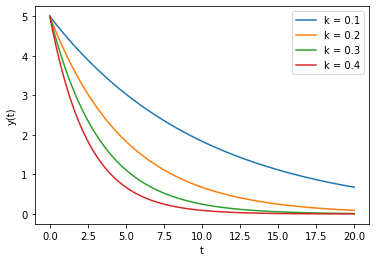

In [0]:
#Solving a simple ODE using odeint
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

#Define constants
k = np.array([.1,.2,.3,.4])
y0 = 5
t = np.linspace(0,20,100)
solution = np.array([])

#define function
def model(y,t, k):
  k=k
  dydt=-k*y
  return dydt

#Solve ODE using different values of k
for i in k:
  y = odeint(model,y0,t, args=(i,))
  solution = np.vstack(y)
  label = 'k = %.1f'%i
  plt.plot(t,solution, label = label)

plt.xlabel('t')
plt.ylabel('y(t)')
plt.legend(loc="upper right")
plt.show()